In [3]:
import pandas as pd
import os
import pandas as pd
import pickle as pkl
import os
import numpy as np
import matplotlib.pyplot as plt
import json
import datetime as dt
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

#plt.style.use('../../fire_style.mplstyle')

In [4]:
col_map = {
        "INCIDENT_IDENTIFIER": "fire_id",
        "INC209R_IDENTIFIER": "report_id",
        "year_y": "year",
        "CURR_INCIDENT_AREA": "incident_area",
        "INC209RU_IDENTIFIER": "resource_id",
        "INC209R_IDENTIFIER": "report_id",
        "RESOURCE_QUANTITY": "quantity",
        "RESOURCE_PERSONNEL": "personnel"
    }

In [6]:
df = pd.read_csv('../../data/raw/resources.csv').rename(columns=col_map)
df.shape

(480143, 7)

In [8]:
resource_df = df.pivot_table(index='report_id', columns='resource', values=['quantity', 'personnel'], aggfunc='sum', fill_value=0)

In [9]:
resource_df.columns = ['_'.join(col) for col in resource_df.columns]

In [10]:
study_df = resource_df.iloc[:, :70]
sum_cols = study_df.sum()
mask = (sum_cols>sum_cols.quantile(.90))


<Axes: title={'center': 'Resource Usage by Type'}>

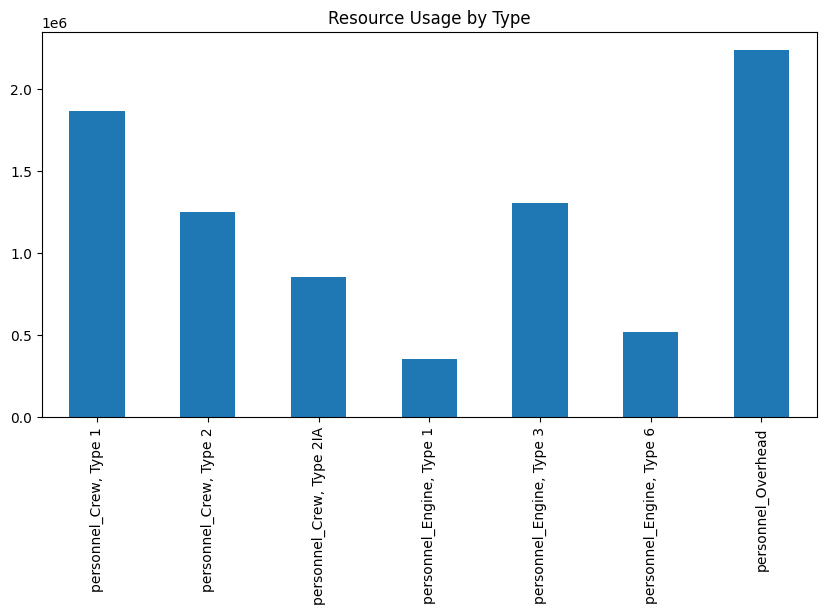

In [11]:
study_df.loc[:,mask].sum().plot(kind='bar', figsize=(10, 5), title='Resource Usage by Type')

<Axes: >

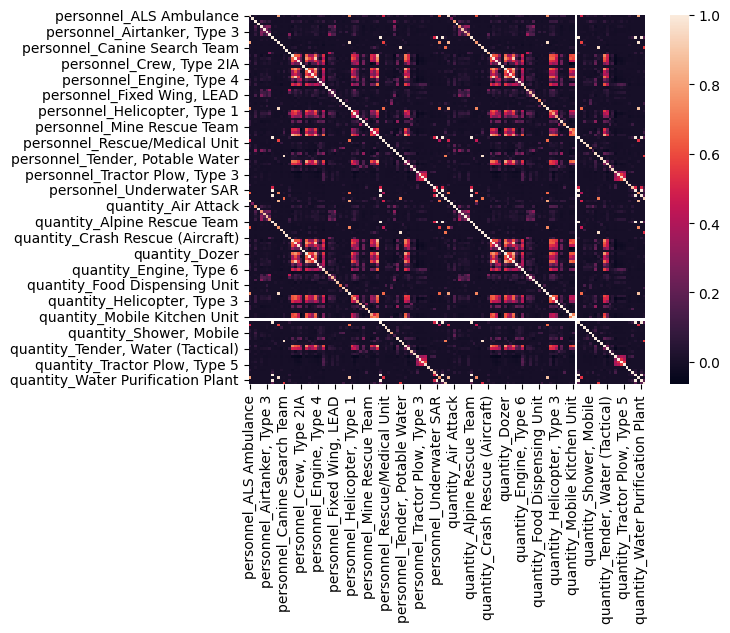

In [12]:
import seaborn as sns
sns.heatmap(resource_df.iloc[:,:].corr())

In [14]:
resource_df.iloc[-1]

personnel_ALS Ambulance              0
personnel_Aerial Apparatus           0
personnel_Air Attack                 1
personnel_Air Supply Truck           0
personnel_Airtanker, Type 1          4
                                    ..
quantity_Truck, Hazmat               0
quantity_Underwater SAR              0
quantity_Urban SAR Team              0
quantity_Water Purification Plant    0
quantity_Water Rescue Team           0
Name: 9276418, Length: 140, dtype: int64

In [13]:
resource_df.to_csv('../data/cleaned/resources.csv')

OSError: Cannot save file into a non-existent directory: '..\data\cleaned'

## Clustering

c:\ProgramData\Anaconda3\envs\wildfirepy38\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\ProgramData\Anaconda3\envs\wildfirepy38\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\ProgramData\Anaconda3\envs\wildfirepy38\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\ProgramData\Anaconda3\envs\wildfirepy38\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default 

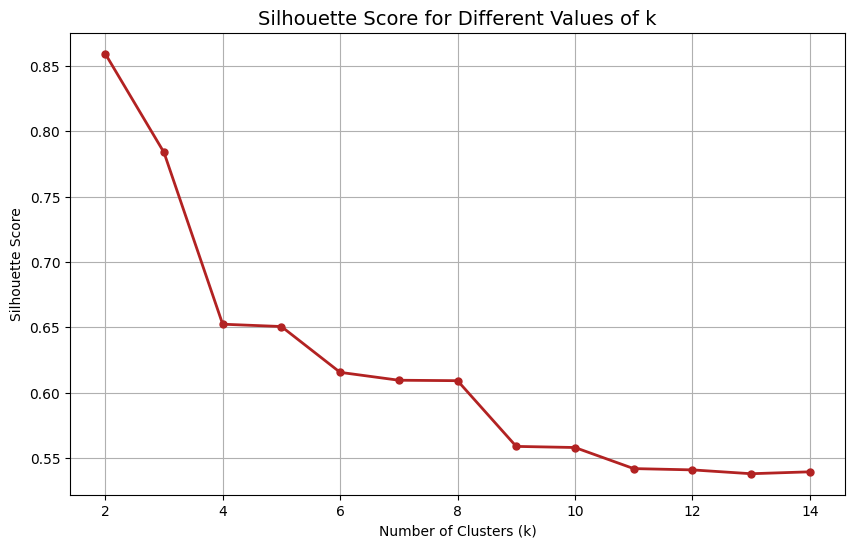

In [142]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
silhouette_scores = []
k_values = range(2, 15)
for k in k_values:
    cluster = KMeans(n_clusters=k, init="k-means++", random_state=0)
    clusters = cluster.fit_predict(resource_df)
    score = silhouette_score(resource_df, clusters)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title("Silhouette Score for Different Values of k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

In [141]:
resource_df['cluster'] = clusters
resource_df['cluster'].value_counts()

cluster
0    30249
3     5162
7     1371
2      777
5      576
1      292
6      101
4       40
Name: count, dtype: int64

In [ ]:
resource_df

## RESTYP_IDENTIFER and resource

In [100]:
injective_check = df.groupby('RESTYP_IDENTIFIER')['resource'].nunique().max() == 1
surjective_check = df.groupby('resource')['RESTYP_IDENTIFIER'].nunique().max() == 1
print(injective_check, surjective_check)

True False


In [101]:
df.groupby('resource')['RESTYP_IDENTIFIER'].nunique().value_counts()

RESTYP_IDENTIFIER
4    49
1     8
2     8
3     5
Name: count, dtype: int64

In [102]:
df.groupby('resource')[['RESTYP_IDENTIFIER', 'year']].nunique().value_counts()

RESTYP_IDENTIFIER  year
4                  4       49
1                  1        8
2                  2        8
3                  3        5
Name: count, dtype: int64

The RESTYP_IDENTIFIER depends on the year. We will use the resource column and drop this one.


<Axes: ylabel='resource'>

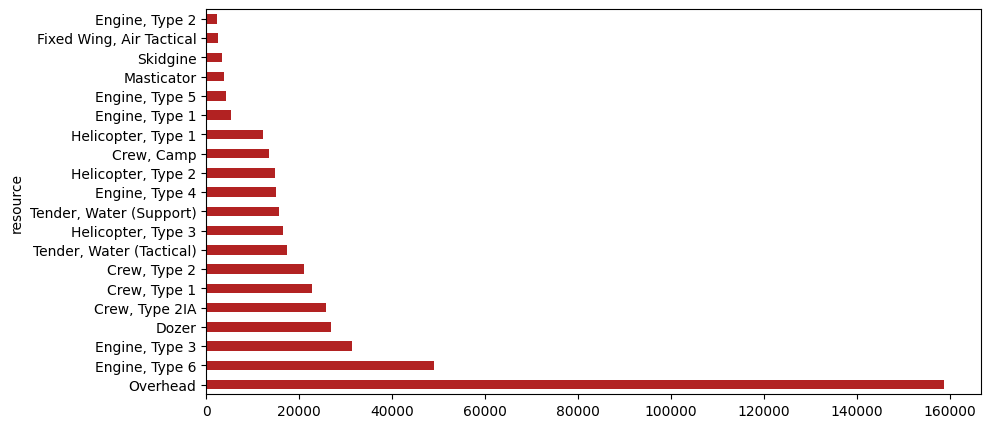

In [103]:
df.resource.value_counts().iloc[:20].plot(kind='barh', figsize=(10, 5))

## Resources qty and personnel

In [108]:
df[['quantity', 'personnel']].describe()

,quantity,personnel
count,480143.000000,480132.000000
mean,2.729418,20.461913
std,8.294515,54.396907
min,0.000000,0.000000
25%,0.000000,2.000000
50%,1.000000,6.000000
75%,2.000000,20.000000
max,810.000000,1610.000000


In [109]:
df[['quantity', 'personnel']].corr()

,quantity,personnel
quantity,1.000000,0.651955
personnel,0.651955,1.000000


In [126]:
df[df['report_id']==df['report_id'].unique()[17]]

,resource_id,report_id,RESTYP_IDENTIFIER,resource,quantity,personnel,year
68,2735849.0,2735841,1536143.0,Dozer,1.0,1.0,2015
69,2735850.0,2735841,1536149.0,"Engine, Type 6",1.0,1.0,2015
70,2735851.0,2735841,1536168.0,Overhead,0.0,0.0,2015


In [97]:
#df.to_csv("../data/cleaned/resources.csv", index=False)

## Resource per report
Is the list of resources per report unique?

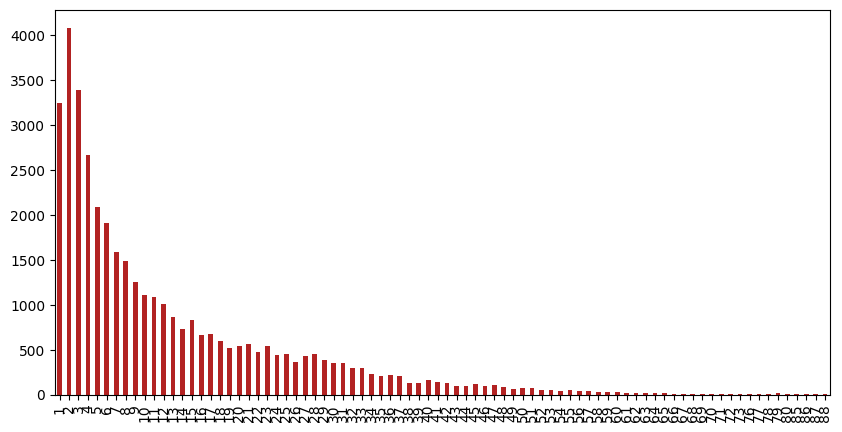

In [76]:
df.groupby('report_id').size().value_counts().sort_index().plot(kind='bar', figsize=(10, 5)); #be careful with this kind of representation

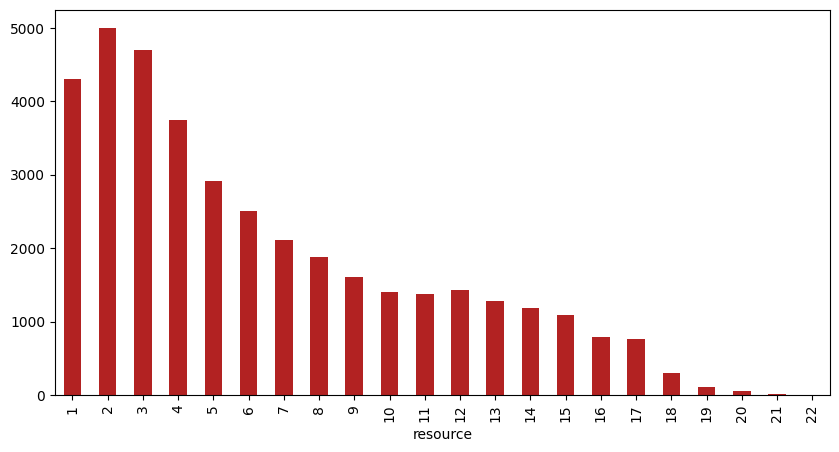

In [77]:
df.groupby('report_id').nunique().resource.value_counts().sort_index().plot(kind='bar', figsize=(10, 5));

C:\Users\benja\AppData\Local\Temp\ipykernel_8236\3303529338.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df.groupby('report_id').nunique().resource == 1]


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).